In [48]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import expit
import time


# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, I)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [49]:
def generate_vector(normalize=False):
    v = np.random.randn(10)
    if normalize:
        sums = 0
        for i in v:
            sums += i * i 
        norm = math.sqrt(sums)
        v = [i*1/norm for i in v]
    return np.array(v)

def generate_label(x_i,w):
    s = expit(np.dot(w,x_i))
    X = np.random.uniform(low=0,high=1)
    y_i = 0
    if X <= s:
        y_i = 1
    return y_i

def generate_data(m):
    x = []
    for i in range(m):
        x.append(generate_vector(normalize=False))
    return np.array(x)

def new_data(m):
    w = generate_vector(normalize=True) 
    x = generate_data(m)
    y = np.array([generate_label(i,w) for i in x])
    return w, x, y 


## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [50]:
from sklearn.linear_model import LogisticRegression

def algorithm1(X,Y):
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X, Y)
    w_t = np.array(clf.coef_[0])
    return w_t

## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

In [51]:
def loss_gradient(x,y,w):
    sigmoid = expit(np.inner(w,x))
    p1 = (sigmoid-y)
    return np.inner(x,p1*sigmoid*(1-sigmoid))

def gradient(x,y,w):
    values = 0
    for i in range(len(x)):
        values+=loss_gradient(x[i],y[i],w)
    return values * 1/len(x[0])

def algorithm2(x,y):
    v = []
    w_t = np.zeros(10)
    for iterations in range(1000):
        w_t -= 0.01*gradient(x,y,w_t)
        v.append(w_t)
    return sum([i for i in v])/len(v)


## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

In [52]:
def stochastic_gradient(x,y,w):
    random = np.random.randint(0,len(x))
    return loss_gradient(x[random],y[random],w)

def algorithm3(x,y):
    w_t = np.zeros(10)
    for iterations in range(1000):
        w_t -= 0.01*stochastic_gradient(x,y,w_t)
    return w_t

## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w - 
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

Logistic Regression	 	Sample Number:   50 	Experiment Time: 0.05058097839355469
Gradient Descent	 	Sample Number:   50 	Experiment Time: 3.4251708984375
Stochastic Gradient Decent 	Sample Number:   50 	Experiment Time: 0.11553001403808594

Logistic Regression	 	Sample Number:  100 	Experiment Time: 0.029864788055419922
Gradient Descent	 	Sample Number:  100 	Experiment Time: 6.533768892288208
Stochastic Gradient Decent 	Sample Number:  100 	Experiment Time: 0.12145209312438965

Logistic Regression	 	Sample Number:  150 	Experiment Time: 0.034336090087890625
Gradient Descent	 	Sample Number:  150 	Experiment Time: 9.532044172286987
Stochastic Gradient Decent 	Sample Number:  150 	Experiment Time: 0.12226486206054688

Logistic Regression	 	Sample Number:  250 	Experiment Time: 0.03910493850708008
Gradient Descent	 	Sample Number:  250 	Experiment Time: 15.068732023239136
Stochastic Gradient Decent 	Sample Number:  250 	Experiment Time: 0.12860703468322754



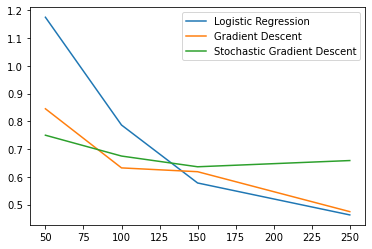

In [53]:
def experiment(m, algorithm,name):
    start = time.time()
    a = []
    for i in range(10):
        w_star, x , y = new_data(m)
        w_new = algorithm(x,y)
        w_sub = w_star-w_new
        w_norm_diff = np.linalg.norm(w_sub)
        a.append(w_norm_diff)
    print(f"{name:5} \tSample Number: {m:4} \tExperiment Time: {time.time()-start}")
    return np.average(a)

a1_m = []
a2_m = []
a3_m = []
M = [50,100,150,250]
for m in M:
    a1_m.append(experiment(m, algorithm1, 'Logistic Regression\t'))
    a2_m.append(experiment(m, algorithm2, 'Gradient Descent\t'))
    a3_m.append(experiment(m, algorithm3, 'Stochastic Gradient Decent'))
    print()

plt.figure()
plt.plot(M, a1_m, label='Logistic Regression')
plt.plot(M, a2_m, label='Gradient Descent')
plt.plot(M, a3_m, label='Stochastic Gradient Descent')
plt.legend()
plt.show()


# Problem 2

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import datasets

In [55]:
cancer = datasets.load_breast_cancer()

For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth (set `n_estimators=10` and `learning_rate=1`), and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

In [56]:
depths = [i for i in range (1,6)]
X,y = cancer.data, cancer.target
accuracy = []

for depth in depths:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), learning_rate=1, random_state=101)
    
    clf.fit(X, y)
    scores = cross_val_score(clf, cancer.data, cancer.target, cv=KFold(n_splits=10, random_state=101, shuffle=True))
    accuracy.append(scores.mean())

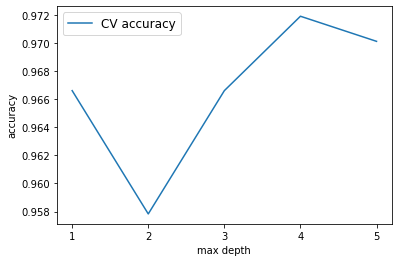

In [57]:
plt.figure()
plt.plot(depths, accuracy, label='CV accuracy')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.legend(fontsize='large')
plt.xticks(depths)
plt.show()